<a href="https://colab.research.google.com/github/rambir4git/sih/blob/master/crop_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install google_images_download
!apt install chromium-chromedriver
!pip install tensorflow-gpu

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import keras as keras

import itertools
import os
import matplotlib.pylab as plt
import numpy as np
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print(" Keras version:", keras.__version__)
tf.config.list_physical_devices('GPU')

TF version: 2.1.0
Hub version: 0.7.0
 Keras version: 2.2.5


Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('gdrive')
#4/vQGS-1x5Dqw4FUamuMe-VJW11SujC8C_WPWCijfQJjozaRelUetzAuw

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
#This code scraps Google Images
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=chrome_options)
from google_images_download import google_images_download   #importing the library
response = google_images_download.googleimagesdownload()   #class instantiation
arguments = {"keywords":"maze field","limit":1,
             "print_urls":False,
             "chromedriver":"/usr/bin/chromedriver",
             "output_directory":"gdrive/My Drive/Colab Notebooks/dataset"}   #creating list of arguments
paths = response.download(arguments)   #passing the arguments to the function

In [3]:
data_dir='gdrive/My Drive/Colab Notebooks/dataset'
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=(299,299), batch_size=32)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 682 images belonging to 10 classes.
Found 2744 images belonging to 10 classes.


In [4]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
                   trainable=True, arguments=dict(batch_norm_momentum=0.997)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build([None, 299, 299, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  20490     
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [7]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=15, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 85 steps, validate for 21 steps
Epoch 1/15
36/85 [===========>..................] - ETA: 8:05 - loss: 2.2693 - accuracy: 0.2963

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


85/85 [==============================] - 1006s 12s/step - loss: 2.0354 - accuracy: 0.4185 - val_loss: 2.8526 - val_accuracy: 0.2619
Epoch 2/15
85/85 [==============================] - 138s 2s/step - loss: 1.5591 - accuracy: 0.6353 - val_loss: 2.0241 - val_accuracy: 0.4479
Epoch 3/15
85/85 [==============================] - 136s 2s/step - loss: 1.3310 - accuracy: 0.7485 - val_loss: 2.3689 - val_accuracy: 0.4182
Epoch 4/15
85/85 [==============================] - 137s 2s/step - loss: 1.1758 - accuracy: 0.8182 - val_loss: 2.0104 - val_accuracy: 0.4673
Epoch 5/15
85/85 [==============================] - 139s 2s/step - loss: 1.0469 - accuracy: 0.8827 - val_loss: 1.8871 - val_accuracy: 0.5536
Epoch 6/15
85/85 [==============================] - 138s 2s/step - loss: 0.9604 - accuracy: 0.9285 - val_loss: 1.8192 - val_accuracy: 0.5729
Epoch 7/15
85/85 [==============================] - 137s 2s/step - loss: 0.8994 - accuracy: 0.9602 - val_loss: 1.6695 - val_accuracy: 0.6414
Epoch 8/15
85/85 [====

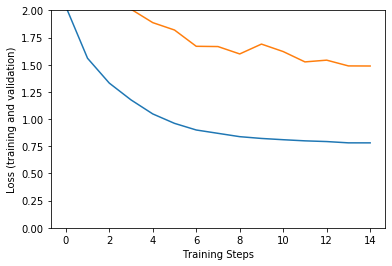

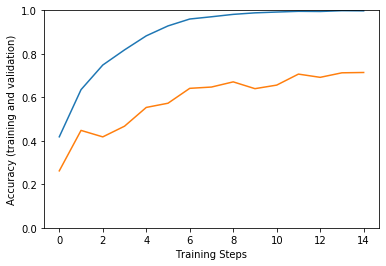

In [8]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [9]:
saved_model_path = "crop_model"
tf.saved_model.save(model, saved_model_path)
label_map=train_generator.class_indices
reverse_label_map = {v: k for k, v in label_map.items()}
print(label_map)
print(reverse_label_map)
import json
with open('labels.json', 'w', encoding='utf-8') as f:
    json.dump(reverse_label_map, f, ensure_ascii=False, indent=0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: crop_model/assets


INFO:tensorflow:Assets written to: crop_model/assets


{'barley fields': 0, 'jute fields': 1, 'maze fields': 2, 'mustard fields': 3, 'paddy fields': 4, 'potato fields': 5, 'sugarcane fields': 6, 'tea fields': 7, 'tomato fields': 8, 'wheat fields': 9}
{0: 'barley fields', 1: 'jute fields', 2: 'maze fields', 3: 'mustard fields', 4: 'paddy fields', 5: 'potato fields', 6: 'sugarcane fields', 7: 'tea fields', 8: 'tomato fields', 9: 'wheat fields'}


In [10]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

87245204

In [11]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Print input shape and type
print(interpreter.get_input_details()[0]['shape'])  # Example: [1 224 224 3]
print(interpreter.get_input_details()[0]['dtype'])  # Example: <class 'numpy.float32'>

# Print output shape and type
print(interpreter.get_output_details()[0]['shape'])  # Example: [1 1000]
print(interpreter.get_output_details()[0]['dtype'])  # Example: <class 'numpy.float32'>

# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

[  1 299 299   3]
<class 'numpy.float32'>
[ 1 10]
<class 'numpy.float32'>


In [0]:
#This is to test the actual_model not lite_model
from keras.preprocessing import image
import numpy as np
from PIL import Image

img=image.load_img("download.jpg",target_size=(299,299))
arr1=image.img_to_array(img)/255.0
arr1 = np.expand_dims(arr1, axis=0)

img=image.load_img("download2.jpg",target_size=(299,299))
arr2=image.img_to_array(img)/255.0
arr2 = np.expand_dims(arr2, axis=0)

img=image.load_img("download3.jpg",target_size=(299,299))
arr3=image.img_to_array(img)/255.0
arr3 = np.expand_dims(arr3, axis=0)

img=image.load_img("download4.jpg",target_size=(299,299))
arr4=image.img_to_array(img)/255.0
arr4 = np.expand_dims(arr4, axis=0)

img=image.load_img("download5.jpg",target_size=(299,299))
arr5=image.img_to_array(img)/255.0
arr5 = np.expand_dims(arr5, axis=0)

img=image.load_img("download6.jpg",target_size=(299,299))
arr6=image.img_to_array(img)/255.0
arr6 = np.expand_dims(arr6, axis=0)

img=image.load_img("download7.jpg",target_size=(299,299))
arr7=image.img_to_array(img)/255.0
arr7 = np.expand_dims(arr7, axis=0)

img=image.load_img("download8.jpg",target_size=(299,299))
arr8=image.img_to_array(img)/255.0
arr8 = np.expand_dims(arr8, axis=0)

images = np.vstack([arr1,arr2,arr3,arr4,arr5,arr6,arr7,arr8])
classes = model.predict_classes(images, batch_size=10)
print(classes)

[26 35 16 16 26 26  0 29]
